In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Create Slope Images

Example notebook to generate slope images from raw data. Basic process:
  1. Subtract superbias
  1. Perform reference pixel correction
  1. Perform linearity correction
  1. Fit slopes of unsaturated data

In [2]:
# Reference pixel correction modules and functions
import ref_pixels
from ref_pixels import robust
from ref_pixels import reffix_hxrg, get_fits_data
from ref_pixels import jl_poly_fit, jl_poly

from ref_pixels.utils import find_sat, cube_fit, hist_indices

# Astropy FITS
from astropy.io import fits

# Progress bar
from tqdm.auto import trange, tqdm

In [3]:
def do_lincorr(data, cf_lincorr, ref_info=[4,4,4,4], in_place=True):
    """ Perform linearity correction on ramp data 
    
    Parameters
    ==========
    data : ndarray
        Bias-subtracted and ref-pixel-corrected ramp data.
        Can either be a cube or single image. Units in DN.
    cf_lincorr : ndarray
        Array of polynomial coefficients describing correction
        factor in order to linearize data values. The input
        shape should either be of size (ncf) or (ncf, ny, nx).
    ref_info : list
        Number of reference pixels [bottom, upper, left, right].
        These are excluded from linearity correction.
    in_place : bool
        If True, will overwrite the input data with the corrected values.
    """
    
    sh_orig = data.shape
    if len(sh_orig)==2:
        nz = 1
        ny, nx = sh_orig
        data = data.reshape([nz,ny,nx])
    else:
        nz, ny, nx = sh_orig
        
    # Create correction factor for each pixel from polynomial coefficients
    # This should work if cf_lincorr has a shape of (ncf) or (ncf, ny, nx)
    corr_fact = np.zeros_like(data)
    for i, cf in enumerate(cf_lincorr):
        corr_fact += cf * data**i
        
    # Make sure reference pixels are excluded
    # [bottom, upper, left, right]
    br, ur, lr, rr = ref_info
    ref_mask = np.zeros([ny,nx], dtype=bool)
    if br>0: ref_mask[0:br,:] = True
    if ur>0: ref_mask[-ur:,:] = True
    if lr>0: ref_mask[:,0:lr] = True
    if rr>0: ref_mask[:,-rr:] = True
    corr_fact[:, ref_mask] = 1
    
    if in_place:
        data *= corr_fact
        data_corr = data
    else:
        data_corr = data * corr_fact
        
    return data_corr.reshape(sh_orig)

# FITS Cubes

Paths to various data and calibration files.

In [10]:
import os

# Assume linearity data to be our science images
sci_dir = '/Users/jarron/SHARK-NIR/20200215_Lin/Lin_250kHz/'
sci_files = np.array([sci_dir + f for f in os.listdir(sci_dir) if f.endswith('.fits')])
sci_files.sort()

In [5]:
# Read in superbias image
bias_path = '/Users/jarron/SHARK-NIR/20200220_Dark/SHARK-NIR_250Hz_superbias_example.fits'
superbias = get_fits_data(bias_path)

In [7]:
# Read in linearity coefficients file
lincorr_path = '/Users/jarron/SHARK-NIR/20200215_Lin/SHARK-NIR_250Hz_lincorr.npy'
cf_lincorr = np.load(lincorr_path)

# Read in saturation values for linearity corrected data
satvals_path = '/Users/jarron/SHARK-NIR/20200215_Lin/SHARK-NIR_250Hz_lincorr_satvals.fits'
sat_vals_corr = get_fits_data(satvals_path)

## Detector timing

Define a detector timing object that houses all the necessary information concerning the pixel and frame clocking, detector size and output channels, etc.

In [8]:
# Get shape information for input file
hdul = fits.open(sci_files[0])
nz, ny, nx = hdul[0].data.shape
hdul.close()

# Detector timing info
if nx<2048 and ny<2048:
    wind_mode = 'WINDOW'
elif ny<2048:
    wind_mode = 'STRIPE'
else:
    wind_mode = 'FULL'
    
det = ref_pixels.detops.det_timing(mode='SHARK_250', wind_mode=wind_mode, xpix=nx, ypix=ny, ngroup=nz)

[    refpix:INFO] RAPID readout mode selected.
[    refpix:INFO] Setting nf=1, nd1=0, nd2=0, nd3=0.


In [9]:
# Time array
tarr = det.times_group_avg
print(tarr)

[  4.278316   8.556632  12.834948  17.113264  21.39158   25.669896
  29.948212  34.226528  38.504844  42.78316   47.061476  51.339792
  55.618108  59.896424  64.17474   68.453056  72.731372  77.009688
  81.288004  85.56632   89.844636  94.122952  98.401268 102.679584
 106.9579  ]


# Get Slopes

Perform superbias subtraction, reference pixel correction, and linearity correction. Then fit slopes to corrected data and save result into an HDUList. 

This example chooses to place each slope image into its own HDU extension, which would preserve header information that might be unique to each science integration (e.g., telescope PA, start and end times, AO information, observing conditions). The user could also place all images into a data cube and save it all into a single Primary FITS extension, but they would have to come up with another method to preserve integration-specific information and telemetry value.

After generating a slope image, can also perform other data reduction procedures, including superdark subtraction, flat field correction, etc.

In [11]:
# Keyword arguments to pass to reference pixel correction before slope fitting
kw_refpix = {
    'nchans': det.nout, 'altcol': True, 'in_place': True,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True, 'perint': False
}

hdulist = fits.HDUList()
for file in tqdm(sci_files):

    # Read data and perform superbias subtraction and reference pixel correction
    data, header = get_fits_data(file, bias=superbias, return_header=True,
                                 reffix=True, **kw_refpix)
    
    # Perform the linearity correction
    data = do_lincorr(data, cf_lincorr, ref_info=det.ref_info)
    
    # Fit the corrected data cube and return fit coefficients
    # This function ignores saturated pixels during the fitting process
    cf_all = cube_fit(tarr, data, deg=1, sat_vals=sat_vals_corr, sat_frac=0.95, ref_info=det.ref_info)
    # Get the slope image (DN/sec)
    slope = cf_all[1]
    
    del data
    
    # Combine slope with header and add to a multi-extension HDUList
    hdu = fits.PrimaryHDU(data=slope, header=header)
    hdu.header['UNITS'] = ('DN/sec', 'Image units')

    hdulist.append(hdu)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (2048, 2048)   float64   
  1                1 ImageHDU        10   (2048, 2048)   float64   
  2                1 ImageHDU        10   (2048, 2048)   float64   
  3                1 ImageHDU        10   (2048, 2048)   float64   
  4                1 ImageHDU        10   (2048, 2048)   float64   
  5                1 ImageHDU        10   (2048, 2048)   float64   
  6                1 ImageHDU        10   (2048, 2048)   float64   
  7                1 ImageHDU        10   (2048, 2048)   float64   
  8                1 ImageHDU        10   (2048, 2048)   float64   
  9                1 ImageHDU        10   (2048, 2048)   float64   
 10                1 ImageHDU        10   (2048, 2048)   float64   
 11                1 ImageHDU        10   (2048, 2048)   float64   
 12                1 ImageHDU        10   (2048, 2048)   float64   
 13  

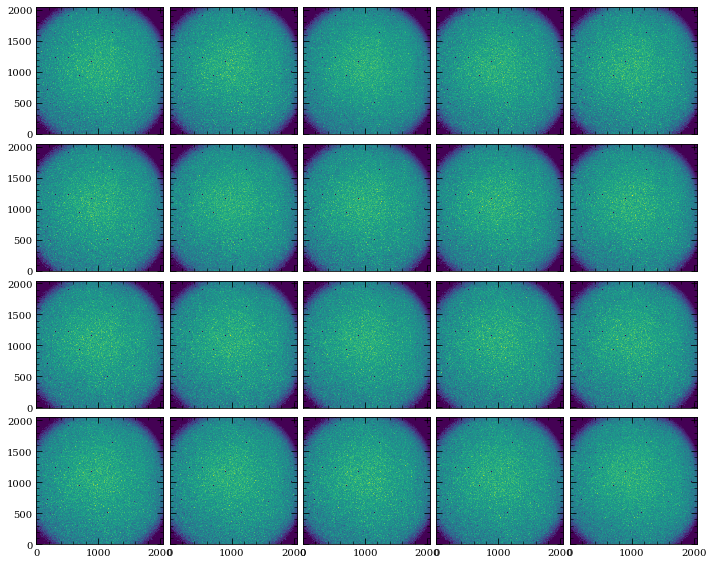

In [13]:
fig, axes = plt.subplots(4,5, sharex=True, sharey=True, figsize=(10,8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    im = hdulist[i].data
    med = np.median(im)
    std = robust.medabsdev(im)
    vmin, vmax = med + 5*std*np.array([-1,1])
    
    ax.imshow(im, vmin=vmin, vmax=vmax)
    
fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [14]:
# Can now save hdulist.writeto()